In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Any
from datetime import datetime, timedelta, time
from tqdm import tqdm
import random
import bisect

In [ ]:
# PARAMETER SETTING

#Seeds
random.seed(42)
np.random.seed(42)

# Plane Simulation Parameters
MAX_RADAR_DISTANCE = 100
MIN_THRESHOLD = 4    
MIN_BUF = 5            
DEVIATION_SPEED = 200  
DT = 1/60   
DATE = (2025, 9, 10, 6, 0, 0)     

PROXIMITY_RANGE = [
    ((100, 10_000_000), (300, 500)),
    ((50, 100), (250, 300)),
    ((15, 50), (200, 250)),
    ((5, 15), (150, 200)),
    ((0, 5), (120, 150)),
]

LOWER_BOUNDS = [r[0][0] for r in PROXIMITY_RANGE]  # [100, 50, 15, 5, 0]
UPPER_BOUNDS = [r[0][1] for r in PROXIMITY_RANGE]  # [10_000_000,100,50,15,5]
MAX_SPEEDS  = [r[1][1] for r in PROXIMITY_RANGE]   # [500, 300, 250, 200, 150]
MIN_SPEEDS = [r[1][0] for r in PROXIMITY_RANGE]    # [300, 250, 200, 150, 120]

# Simulation Parameters
LAMBDA = 1/60
SIMULATION_TIME = 18 * 60
DATE = (2025, 9, 10, 6, 0, 0)
CLOSING_TIME = 60 # in minutes since airport simulation start


In [ ]:
def update_speed(v, low, high):
    return max(low, min(high, v))

def find_range_idx(x: float) -> int:
    """Returns current distance range index"""
    for i, (dist_range, _) in enumerate(PROXIMITY_RANGE):
        dmin, dmax = dist_range
        if dmin <= x <= dmax:
            return i
        
    if x < 0:
        return len(PROXIMITY_RANGE) - 1
    return 0

def minutes_from_AEP(curr_pos: float, curr_speed: float, curr_range_idx: int) -> float:
    """
    Returns minutes left to arrive at AEP from current position, considering current speed and no congestion
    """
    if curr_pos <= 0:
        return 0

    lower = LOWER_BOUNDS
    upper = UPPER_BOUNDS

    x = curr_pos
    remaining_time = 0 # in hs

    for i in range(len(PROXIMITY_RANGE)):
        high = upper[i]
        low = lower[i+1] if i+1 < len(lower) else 0

        # Longitud del tramo actual [lo, hi] que nos queda por recorrer
        actual_pos = min(x, high)
        lower_bound = low
        segment = max(0.0, actual_pos - lower_bound)
        if segment <= 0:
            continue

        vmax = MAX_SPEEDS[i]

        estimated_speed = min(vmax, curr_speed) if i == curr_range_idx else vmax
        remaining_time += segment / estimated_speed

        x = low
        if x <= 0:
            break

    return remaining_time * 60.0  # minutos

@dataclass
class Plane:
    pos: float = MAX_RADAR_DISTANCE  # MN a AEP
    range_idx: int = 0 # PROXIMITY_RANGE idx
    dist_range: Tuple[int, int] = PROXIMITY_RANGE[0][0]
    speed_range: Tuple[int, int] = PROXIMITY_RANGE[0][1]
    speed: float = PROXIMITY_RANGE[0][1][1]  # knots
    dir: int = -1 # -1 towards AEP, 1 away from AEP
    id: Optional[int] = None
    status: str = "on-time" # on-time | delayed | diverted | landed
    landed: bool = False
    sta: datetime = None  # Scheduled Time of Arrival
    eta: datetime = None  # Estimated Time of Arrival
    ata: datetime = None  # Actual Time of Arrival
    dt: float = DT  # step size
    adjusting_speed: bool = False
    prop_bounce: float = 0 # Probability to interrupt landing and go back to plane queue
    history: List[Tuple[float, float, int, int, str]] = field(default_factory=list)

    def update_ranges(self):
        """Updates ranges based on current position"""
        idx = find_range_idx(self.pos)
        self.range_idx = idx
        self.dist_range = PROXIMITY_RANGE[idx][0]
        self.speed_range = PROXIMITY_RANGE[idx][1]

        self.speed = update_speed(self.speed, self.speed_range[0], self.speed_range[1])

    def update_eta(self, now: datetime):
        """Updates ETA based on current time"""
        time_left_min = minutes_from_AEP(self.pos, self.speed, self.range_idx)
        self.eta = now + timedelta(minutes=time_left_min)


    def find_gap(self, plane_list: List['Plane']) -> int:
        """
        Returns index where self should be inserted in the plane queue.
        Return value respects 5 min buffer with next and previous plane.
        Returns -1 if no gap was found, -10 if plane is out of bounds
        """
        if self.pos > MAX_RADAR_DISTANCE:
            return -10

        if not plane_list or len(plane_list) == 0:
            # If plane_list is empty and plane is in radar distance, it can be inserted at first pos.
            return 0 if self.pos <= MAX_RADAR_DISTANCE else -1

        positions = [p.pos for p in plane_list]

        # If there are planes with no position, something went wrong previously
        if any(e is None for e in positions): return -1
        # If for some reason positions are not ordered, something went wrong previously
        if not all(positions[i] <= positions[i + 1] for i in range(len(positions) - 1)): return -1

        idx = bisect.bisect_left(positions, self.pos)

        delta = timedelta(minutes=MIN_BUF)

        # Check if next plane is 5 mins ahead
        if idx - 1 >= 0:
            if timedelta(minutes=(abs(self.pos - positions[idx - 1]) / self.speed) * 60) < delta:
                return -1
        # Check if previous plane is 5 mins behind
        if idx < len(positions):
            if timedelta(minutes=((positions[idx] - self.pos) / self.speed) * 60) < delta:
                return -1

        return idx

    @staticmethod
    def calc_eta(x: float, speed: float, rng: int) -> float:
        """Returns estimated time of arrival based on now and minutes from AEP."""
        rng = max(0, min(rng, len(PROXIMITY_RANGE) - 1))
        return minutes_from_AEP(x, speed, rng)

    def tick(self, now: datetime, airport_open: bool):
        """
        Avanza un tick:
          - Actualiza posición y estado (aterrizado si pos<=0)
          - Recalcula rangos y ETA
          - Actualiza status on-time/delayed según STA si está disponible
        """
        
        # Move
        if self.pos == 100 and not airport_open: # Handle airport closed and new airplane arriving
            self.status = "diverted"
            return
        
        self.pos += self.speed * self.dt * self.dir
        t0 = datetime(*DATE)  # 2025-09-10 06:00:00
        minutes_since_start = (now - t0).total_seconds() / 60.0
        if self.pos <= 0:
            self.pos = 0
            will_bounce = np.random.uniform(0, 1) # deal with landing interruptions
            if not airport_open: will_bounce = -1 # will always be < prop_bounce so arrving plane will bounce and go back to queue
            
            if will_bounce < self.prop_bounce:
                self.dir = 1
                self.speed = DEVIATION_SPEED
                self.status = "bounced"
            else:    
                self.status = "landed"
                self.landed = True
                self.ata = now
                self.eta = now
            self.history.append((minutes_since_start, self.pos, self.speed, self.dir, self.status))
            return

        # Update ranges and eta
        if self.dir == -1:
            self.update_ranges()
        self.update_eta(now)

        if self.sta is not None and self.eta is not None:
            self.status = "delayed" if self.eta > self.sta else "on-time"
        self.history.append((minutes_since_start, self.pos, self.speed, self.dir, self.status))

    def update(self, plane_list: List['Plane'], plane_idx: int) -> Dict[str, Any]:
        """
        Lógica de espaciado/velocidad/desvío.
        NO modifica plane_list. Devuelve una acción para aplicar afuera:
          - {"action": "none"|"insert"|"divert", ...}
        """
        if self.status == "diverted":
            return {"action": "divert", "status": self.status, "idx": -10}
        
        if self.status == "bounced":
            self.status = "delayed"
            return {"action": "reposition", "status": self.status, "idx": -1}
        if self.landed:
            return {"action": "none", "status": self.status, "idx": -1}

        # Plane is moving away from AEP
        if self.dir == 1:
            if self.pos <= 5:
                return {"action":"none", "status": self.status, "idx": -1} 
            idx = self.find_gap(plane_list)
            if idx == -10:
                self.status = "diverted"
                return {"action": "divert", "status": self.status, "idx": -10}
            elif idx == -1:
                return {"action":"none", "status": self.status, "idx": -1} 
            else:
                self.dir = -1
                self.adjusting_speed = False
                self.speed = self.speed_range[1]
                return {"action": "insert", "status": self.status, "idx": idx}

        # Moving towards AEP and self is not first plane
        if 0 < plane_idx < len(plane_list) and plane_list[plane_idx - 1].eta is not None and self.eta is not None:
            next_plane = plane_list[plane_idx - 1]
            time_gap = ((self.pos - next_plane.pos) / self.speed) * 60

            if time_gap < MIN_THRESHOLD:
                self.adjusting_speed = True

            if self.adjusting_speed:
                if time_gap >= MIN_BUF:
                    self.adjusting_speed = False
                    self.speed = self.speed_range[1]
                else:
                    # keep safety speed until MIN_BUF is achieved
                    self.speed = next_plane.speed - 20
            else:
                # Updte speed to max permitted speed
                self.speed = self.speed_range[1]

            # If self fell out of min speed, 
            if self.speed < self.speed_range[0]:
                self.dir = 1
                self.adjusting_speed = False
                self.speed = DEVIATION_SPEED
                return {"action": "reposition", "status": self.status}

        return {"action": "none", "status": self.status}


In [ ]:
from dataclasses import dataclass
from datetime import datetime, timedelta
from typing import List, Dict, Any, Tuple, Optional
import numpy as np

@dataclass
class Handler:
    n_iters: int = 1  # por si querés correr varias simulaciones y guardar métricas
    arrival_rate: float = 1 / 60
    closing_time: int = SIMULATION_TIME
    airport_open: bool = True

    def create_plane(self, now: datetime) -> 'Plane':
        p = Plane()
        minutes = Plane.calc_eta(p.pos, p.speed, p.range_idx)
        p.sta = now + timedelta(minutes=minutes)
        p.eta = p.sta
        return p

    def sort_incoming(self, incoming_planes: List['Plane']) -> None:
        old_incoming = incoming_planes.copy()
        incoming_planes.sort(key=lambda x: (x.pos is None, x.pos))
        # Sanity check, nunca puede haber un avion "mas adelante" pero atras en la fila
        # assert all(old_incoming[i] == incoming_planes[i] for i in range(len(old_incoming)))

    def simulate(self) -> Dict[str, Any]:
        results: Dict[str, Any] = {
            "simulations": []
        }
            
        for sim in range(self.n_iters):
            now = datetime(*DATE)
            all_planes: List[Plane] = []
            incoming_planes: List[Plane] = []
            repositioning_planes: List[Plane] = []

            landed_count = 0
            diverted_count = 0
            reposition_count = 0

            for t in range(SIMULATION_TIME):
                if self.closing_time != 0:
                    if self.closing_time < t <= self.closing_time + 30:
                        self.airport_open = False
                    else:
                        self.airport_open = True
                        
                if np.random.uniform(0, 1) <= self.arrival_rate:
                    p = self.create_plane(now)
                    all_planes.append(p)
                    incoming_planes.append(p)

                for p in all_planes:
                    if (not p.landed) and (p.status != "diverted"): # only on-air planes are updated
                        p.tick(now, self.airport_open)

                # Sanity check
                self.sort_incoming(incoming_planes)

                i = 0
                while i < len(incoming_planes):
                    p = incoming_planes[i]

                    if p.landed or p.status == "landed":
                        landed_count += 1
                        incoming_planes.pop(i)
                        # no update i bc removed element
                        continue

                    res = p.update(incoming_planes, i)
                    action = res.get("action", "none")

                    if action == "reposition": # plane has moved to repositioning queue
                        reposition_count += 1
                        repositioning_planes.append(p)
                        incoming_planes.pop(i)
                        # no update i bc removed element
                        continue

                    if action == "divert":
                        diverted_count += 1
                        incoming_planes.pop(i)
                        # no update i bc removed element
                        continue

                    i += 1

                j = 0
                while j < len(repositioning_planes):
                    p = repositioning_planes[j]
                    res = p.update(incoming_planes, -1)
                    action = res.get("action", "none")

                    if action == "insert":
                        idx = res.get("idx", None)
                        if idx is not None and idx >= 0:
                            if idx > len(incoming_planes):
                                idx = len(incoming_planes)
                            incoming_planes.insert(idx, p)
                            repositioning_planes.pop(j)
                        self.sort_incoming(incoming_planes) # Sanity check
                        # no update j bc removed element
                        continue

                    if action == "divert":
                        diverted_count += 1
                        repositioning_planes.pop(j)
                        # no update j bc removed element
                        continue

                    j += 1

                now += timedelta(minutes=1)

            results["simulations"].append({
                "simulation_id": sim,
                "landed": landed_count,
                "diverted": diverted_count,
                "reposition_count": reposition_count,
                "total_planes": len(all_planes)
            })

        return results, all_planes

In [5]:
from tqdm import tqdm
rate = np.linspace(1/60, 1, 100)
mean_planes = []
mean_landings = []
mean_diversions = []
mean_reposition = []
std_planes = []
std_landings = []
std_diversions = []
std_reposition = []

for r in tqdm(rate, desc="Simulation:"):
    h = Handler(1000, r)
    results, _ = h.simulate()
    df = pd.DataFrame.from_records(results["simulations"])
    mean_planes.append(df["total_planes"].mean())
    mean_landings.append(df["landed"].mean())
    mean_diversions.append(df["diverted"].mean())
    mean_reposition.append(df["reposition_count"].mean())

    std_planes.append(df["total_planes"].std())
    std_landings.append(df["landed"].std())
    std_diversions.append(df["diverted"].std())
    std_reposition.append(df["reposition_count"].std())

Simulation:: 100%|██████████| 100/100 [2:11:00<00:00, 78.61s/it] 


In [20]:
simulations = {"rate":rate, "mean_planes":mean_planes, "std_planes":std_planes,
               "mean_diversions":mean_diversions, "std_diversions":std_diversions,
               "mean_landings":mean_landings, "std_landings":std_landings,
               "mean_reposition":mean_reposition, "std_reposition":std_reposition}
df = pd.DataFrame.from_dict(simulations)
df

,rate,mean_planes,std_planes,mean_diversions,std_diversions,mean_landings,std_landings,mean_reposition,std_reposition
0,0.016667,18.025,4.209762,0.001,0.031623,17.668,4.174830,2.631,2.400542
1,0.026599,28.812,5.541061,0.011,0.104355,28.180,5.469325,7.126,4.437997
2,0.036532,39.455,6.352821,0.048,0.236118,38.501,6.276894,13.446,6.473716
3,0.046465,50.377,6.725035,0.140,0.403190,49.183,6.521660,22.149,8.181426
4,0.056397,60.705,7.503218,0.354,0.699409,59.002,7.223862,31.807,10.463998
...,...,...,...,...,...,...,...,...,...
95,0.960269,1037.307,6.396223,893.861,6.319463,131.972,0.391624,901.506,5.970562
96,0.970202,1047.912,5.541567,904.242,5.534986,132.105,0.355107,911.110,5.353743
97,0.980135,1058.464,4.775931,914.602,4.672411,132.247,0.438387,921.063,4.610671
98,0.990067,1069.412,3.270620,924.992,3.114424,132.619,0.485876,931.543,3.237380


In [19]:
std_planes = []
std_landings = []
std_diversions = []
std_reposition = []
sims = np.arange(1, 5101, 100)
for s in tqdm(sims, desc="Simulating"):
    h = Handler(s, 3/60)
    results, _ = h.simulate()
    df = pd.DataFrame.from_records(results["simulations"])
    std_planes.append(df["total_planes"].std())
    std_landings.append(df["landed"].std())
    std_diversions.append(df["diverted"].std())
    std_reposition.append(df["reposition_count"].std())

Simulating: 100%|██████████| 51/51 [32:45<00:00, 38.54s/it]


In [20]:
simulations = {"n":sims, "std_planes":std_planes,
               "std_diversions":std_diversions,
               "std_landings":std_landings,
               "std_reposition":std_reposition}
df = pd.DataFrame.from_dict(simulations)
df

,n,std_planes,std_diversions,std_landings,std_reposition
0,1,NaN,NaN,NaN,NaN
1,101,6.242778,0.170613,6.338660,11.228279
2,201,6.924389,0.156135,6.707013,11.947235
3,301,7.278840,0.161115,7.133543,12.477550
4,401,6.840527,0.225163,6.727922,12.013772
5,501,7.293269,0.207311,7.159216,13.363506
6,601,6.805254,0.171143,6.653283,11.991931
7,701,7.179575,0.149859,7.040419,12.776469
8,801,7.018389,0.144564,6.888031,12.931118
9,901,7.251177,0.183154,7.139808,12.770864


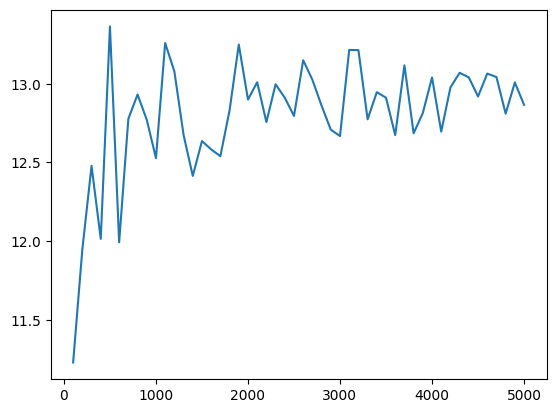

In [24]:
plt.plot(sims, df["std_reposition"])

In [39]:
import sys
import pygame

# Si no está definida en tu entorno:
try:
    SIMULATION_TIME
except NameError:
    SIMULATION_TIME = 1080

def main():
    pygame.init()

    WIDTH, HEIGHT = 1500, 800
    screen = pygame.display.set_mode((WIDTH, HEIGHT))
    pygame.display.set_caption("Pygame 1500x800")
    clock = pygame.time.Clock()

    BACKGROUND = (2, 2, 255)
    BLACK = (0, 0, 0)
    WHITE = (255, 255, 255)

    # Botón cuadrado (abajo-izquierda)
    BTN_SIZE = 60
    BTN_X, BTN_Y = 10, HEIGHT - BTN_SIZE - 10
    button_rect = pygame.Rect(BTN_X, BTN_Y, BTN_SIZE, BTN_SIZE)

    paused = False
    i = 0  # iteración de simulación
    running = True

    while running:
        # --- Eventos ---
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.MOUSEBUTTONDOWN and event.button == 1:
                if button_rect.collidepoint(event.pos):
                    paused = not paused  # toggle

        # --- Lógica de simulación ---
        if not paused and i < SIMULATION_TIME:
            i += 1
            # ... tu lógica por-tick ...

        # --- Dibujo ---
        screen.fill(BACKGROUND)

        # Botón (colores según estado)
        if paused:
            rect_color = WHITE
            tri_color = BLACK
        else:
            rect_color = BLACK
            tri_color = WHITE

        pygame.draw.rect(screen, rect_color, button_rect, border_radius=8)

        # Triángulo "play" centrado dentro del botón
        # proporciones para que quede bien en un cuadrado
        left_x   = BTN_X + int(BTN_SIZE * 0.30)
        right_x  = BTN_X + int(BTN_SIZE * 0.70)
        top_y    = BTN_Y + int(BTN_SIZE * 0.25)
        bottom_y = BTN_Y + int(BTN_SIZE * 0.75)
        mid_y    = BTN_Y + BTN_SIZE // 2

        tri_points = [(left_x, top_y), (left_x, bottom_y), (right_x, mid_y)]
        pygame.draw.polygon(screen, tri_color, tri_points)

        pygame.display.flip()
        clock.tick(60)

    pygame.quit()
    sys.exit()

if __name__ == "__main__":
    main()


SystemExit: 